In [1]:
# AG_ cluster initialization for diffusivity calculations
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy import stats
import time
#import numexpr as ne
import xarray as xr
rEarth = 6371220. #in m ##  get from file variable #f_in.sphere_radius
from netCDF4 import Dataset

In [2]:
##
#find clusters from initial file
# select density layer global data
path='/global/cscratch1/sd/garanaik/e3sm_scratch/cori-knl/'
den=1026 # input which layer required for filter

path_out="./gulfstream/d_1026_c_1d_r100_4/"

path_ini='/global/cscratch1/sd/garanaik/data/'
data_pt_ini = xr.open_dataset(path_ini+'particles_17011_18to6_16000_dt30min_test_41nb_jan_jul_culled.nc')
itemindex = np.where(data_pt_ini.buoyancyParticle[0,:]==den)
n=itemindex[0]
np1=(n[0]);npm1=(n[-1]) # min and max index for particular buoyancy layer
index=np.arange(np1,npm1) #index of all particles belonging to density layer
print(index.shape)  #3281952 84y, 1027d,  #3281952 85y, 1027d,

data_den_ini=data_pt_ini.sel(nParticles=slice((n[0]),(n[-1])))  


llon=data_den_ini.lonParticle[:,:].T
llat=data_den_ini.latParticle[:,:].T


### cluster grid points # either selected domain or global
#x,y=np.meshgrid(np.linspace(-90,-20,71),np.linspace(20,50,31)) #cluster center at 1 degree
x,y=np.meshgrid(np.linspace(-90,-20,71),np.linspace(20,50,31))  #test 
x=np.ravel(np.deg2rad(x)); y=np.ravel(np.deg2rad(y))


(2025214,)


In [3]:
#cluster, circular
radius=100000# 100km= 100,000 m
import time
t1 = time.time()
radiustree = radius / (rEarth * np.sin(np.maximum(np.abs(np.min(y)),np.abs(np.max(y)))))  #y is lat, x is long
#radiustree = radius / (rEarth * np.sin(np.abs(45)))
print(time.time()-t1)
print(radiustree)


t1 = time.time()
from scipy.spatial import cKDTree as KDTree
allparticles = KDTree(np.vstack((llon[:,0],llat[:,0])).T) #llon[:,0] nparticles,time
#print(time.time()-t1)
search = KDTree(np.vstack((x,y)).T)                       # x,y cluster centers  defined...
#print(time.time()-t1)
clusters = search.query_ball_tree(allparticles, radiustree)
print(time.time()-t1) 


Nclusters = x.ravel().shape[0]
Nclusters

0.00046133995056152344
0.020489125934001318
2.4800212383270264


2201

In [4]:
# convert to lat lon in degree
def latlon_from_xyz(xp,yp,zp,r=rEarth):
    rinv=1/r 
    #plat=np.rad2deg(np.arcsin(zp/ np.sqrt(xp**2 + yp**2 + zp**2)))
    plat=(np.rad2deg(np.arcsin(zp*rinv)))
    plon=(np.rad2deg(np.arctan2(yp, xp)))
    return plat, plon

def normalized_haversine_formula(phi1, phi2, lam1, lam2,r=rEarth):
    
    #phi2=np.deg2rad(phi2)
    #phi1=np.deg2rad(phi1)
    #lam1=np.deg2rad(lam1)
    #lam2=np.deg2rad(lam2)
    
    dphi =( phi2 - phi1)
    dlam = (lam2 - lam1)

    a = np.sin(dphi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlam/2.0)**2
    c = r*2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0-a))

    return c

def spherical_bearing(phi1, phi2, lam1, lam2): 
     
    #phi2=np.deg2rad(phi2)
    #phi1=np.deg2rad(phi1)
    #lam1=np.deg2rad(lam1)
    #lam2=np.deg2rad(lam2)
    
    dphi = (phi2 - phi1)
    dlam = (lam2 - lam1)

    return np.arctan2(np.sin(dlam)*np.cos(phi2), np.cos(phi1)*np.sin(phi2) - np.sin(phi1)*np.cos(phi2)*np.cos(dlam)) #}}}

def signed_distances(phi1, phi2, lam1, lam2, r=rEarth):  #{{{
  
    dx = normalized_haversine_formula(phi1, phi1, lam1, lam2,r )
    dy = normalized_haversine_formula(phi1, phi2, lam1, lam1,r )
    # fix orientation of points
    bearing = spherical_bearing(phi1, phi2, lam1, lam2)
    # because arctan2 returns results from -pi to pi for bearing, flip values to get right sign
    dx -= 2*dx*(bearing < 0)
    dy -= 2*dy*(abs(bearing) > np.pi/2.0)
    ux = dx/(24.*60.*60.*1)  #m/s
    uy = dy/(24.*60.*60.*1)  #m/s
#    ux = dx/(24.*60.*60.*2)  #m/s
#    uy = dy/(24.*60.*60.*2)  #m/s
   
    return ux, uy #}}}  #velocity with dt 1day


def bootstrap_ci(data,rep):
    n=len(data)
    xb = np.random.choice(data, (n, rep), replace=True)
    yb = 1/np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
    upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)
    
    
    return np.nanmean(upper),np.nanmean(lower),np.nanmean(yb)
 
def cluster_mean_dispersion(plat,plon,r):   #here plat, plon corresponds to that of all 
                                             #particles in one cluster, one realization, one time step, one layer
    clat=np.nanmean(plat)
    clon=np.nanmean(plon)
    
    
    dx = normalized_haversine_formula(clat, clat, clon, plon, r)
    dy = normalized_haversine_formula(clat, plat, clon, clon, r)
    dr = normalized_haversine_formula(clat, plat, clon, plon, r)
    
    bearing = spherical_bearing(clat, plat, clon, plon)
    dx -= 2*dx*(bearing < 0)
    dy -= 2*dy*(np.fabs(bearing) > np.pi/2.0)
    
    dxdx_sum = np.sum(dx*dx)/(len(plat)-1)
    dydy_sum = np.sum(dy*dy)/(len(plat)-1)
    dxdy_sum = np.sum(dx*dy)/(len(plat)-1)
    drdr_sum = np.sum(dr*dr)/(len(plat)-1)
    
    return clon,clat,dxdx_sum,dydy_sum,dxdy_sum,drdr_sum,len(plat) 

def corr(u):
    rr= np.zeros((len(u[:,0]),len(u[0,:])))
    for i in np.arange(len(u[:,0])):
        uu=u[i,:]
        r=(np.correlate(uu,uu,mode="full"))
        r = r[r.size//2:]
    rr[i,:]=r
        #print(r.shape)
    return np.nanmean(rr,axis=0)

In [7]:
#read all realizations_ all particles_to den layer
#each file corresponds to each realization of 6 month data
# this part can be combined to one dataset with all realzations, time, particles.
# For now, I have kept the realizations fies separate

#input file read
path='/global/cscratch1/sd/garanaik/e3sm_scratch/cori-knl/'
data=xr.open_mfdataset(path+
   r'E3SM_pio2_one-year_test_oRRS18to6v3_pt_16000_4096_4096_256_Ldt30min_41nb_culled_withrestart_from81yr/'
   r'run/analysis_members/*.nc',concat_dim="Time",combine='nested')
#data corresponding to density layer
data_den=data.sel(nParticles=slice((n[0]),(n[-1])),Time=slice(0,180)) 

#convert to lat and long
import time
t1 = time.time()
plat,plon=latlon_from_xyz(data_den.xParticle.values,data_den.yParticle.values,data_den.zParticle.values)
z=data_den.zLevelParticle.values
print(time.time() - t1)  #88.12878680229187


/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arcsin
  """


88.12878680229187


In [8]:
#lat, lon depth from input file, all time
plat_r=np.deg2rad(plat)
plon_r=np.deg2rad(plon)
llon_allt=plon_r.T
llat_allt=plat_r.T
zt=z.T

# size of cluster, partcles, time
Ntime=data_den.xParticle[:,0].shape[0]
Nparticles=data_den.xParticle[0,:].shape[0]
Nclusters = x.ravel().shape[0]

#start of cluster analysis

mux      = np.zeros((Ntime,Nclusters))
muy      = np.zeros((Ntime,Nclusters))
dxdx     = np.zeros((Ntime,Nclusters))
dydy     = np.zeros((Ntime,Nclusters))
dxdy     = np.zeros((Ntime,Nclusters))
drdr     = np.zeros((Ntime,Nclusters))
Npart    = np.zeros((Ntime,Nclusters))
depth    = np.zeros((Ntime,Nclusters))
urms     = np.zeros((Ntime-1,Nclusters))
vrms     = np.zeros((Ntime-1,Nclusters))
umean    = np.zeros((Ntime-1,Nclusters))
vmean    = np.zeros((Ntime-1,Nclusters))
rx    = np.zeros((Ntime-1,Nclusters))
ry    = np.zeros((Ntime-1,Nclusters))

t1 = time.time()
for c in np.arange(Nclusters):
    t2 = time.time()
    ind=clusters[c]
    #print(len(ind))
    if (len(ind)>0):
        
        uvel,vvel   = signed_distances(plat_r[:-1,ind], plat_r[1:,ind],plon_r[:-1,ind], plon_r[1:,ind])
        u_allt=uvel[:,:].T
        v_allt=vvel[:,:].T
        #print(u_allt.shape) #ind, time
    
        p_u=u_allt-np.nanmean(u_allt,axis=0)
        p_v=v_allt-np.nanmean(v_allt,axis=0)
        #print(p_u.shape)
        rrx = corr(p_u)
        rry = corr(p_v)
        rx[:,c]=rrx
        ry[:,c]=rry
        urms[:,c]=np.nanstd(p_u)
        vrms[:,c]=np.nanstd(p_v)
        umean[:,c]=np.nanmean(p_u)
        vmean[:,c]=np.nanmean(p_v)  
        for t in np.arange(Ntime-1):
            p_lat=llat_allt[ind,t]
            p_lon=llon_allt[ind,t]
            mux[t,c],muy[t,c], dxdx[t,c],dydy[t,c],dxdy[t,c],drdr[t,c], Npart[t,c]=cluster_mean_dispersion(p_lat,p_lon,r=rEarth)
                  
    
    print(c,"time per cluster=",time.time()-t2)#5,0.1249542236328125, 844,0.22299627304077148
print(time,"time per time=",time.time()-t1)    


# save each realization cluster data
#import _pickle as pickle
#pickle.dump(mux,open(path_out+"mux_81.p","wb"))
#pickle.dump(muy,open(path_out+"muy_81.p","wb"))
#pickle.dump(dxdx,open(path_out+"dxdx_81.p","wb"))
#pickle.dump(dydy,open(path_out+"dydy_81.p","wb"))
#pickle.dump(dxdy,open(path_out+"dxdy_81.p","wb"))
#pickle.dump(drdr,open(path_out+"drdr_81.p","wb"))
#pickle.dump(Npart,open(path_out+"Npart_81.p","wb"))
#pickle.dump(depth,open(path_out+"depth_81.p","wb"))
#pickle.dump(urms,open(path_out+"urms_81.p","wb"))
#pickle.dump(vrms,open(path_out+"vrms_81.p","wb"))
#pickle.dump(umean,open(path_out+"umean_81.p","wb"))
#pickle.dump(vmean,open(path_out+"vmean_81.p","wb"))   
#pickle.dump(rx,open(path_out+"rx_81.p","wb"))
#pickle.dump(ry,open(path_out+"ry_81.p","wb"))  

0 time per cluster= 5.7220458984375e-06
1 time per cluster= 2.384185791015625e-06
2 time per cluster= 0.06502580642700195
3 time per cluster= 0.10204839706420898
4 time per cluster= 0.12503600120544434
5 time per cluster= 0.1249542236328125
6 time per cluster= 0.14554476737976074
7 time per cluster= 0.11659359931945801
8 time per cluster= 0.11482501029968262
9 time per cluster= 0.11717653274536133
10 time per cluster= 0.11697959899902344
11 time per cluster= 0.10786962509155273
12 time per cluster= 0.0926516056060791
13 time per cluster= 0.07432699203491211
14 time per cluster= 0.0730736255645752
15 time per cluster= 0.08976292610168457
16 time per cluster= 0.11377310752868652
17 time per cluster= 0.13247346878051758
18 time per cluster= 0.15058493614196777
19 time per cluster= 0.08270025253295898
20 time per cluster= 0.09156417846679688
21 time per cluster= 0.09869813919067383
22 time per cluster= 0.11254477500915527
23 time per cluster= 0.11345958709716797
24 time per cluster= 0.1042

199 time per cluster= 0.11267495155334473
200 time per cluster= 0.12528038024902344
201 time per cluster= 0.11096954345703125
202 time per cluster= 0.1074991226196289
203 time per cluster= 0.1063833236694336
204 time per cluster= 0.11020588874816895
205 time per cluster= 0.10811853408813477
206 time per cluster= 0.10685992240905762
207 time per cluster= 0.10735154151916504
208 time per cluster= 0.11021804809570312
209 time per cluster= 0.1055750846862793
210 time per cluster= 0.1168060302734375
211 time per cluster= 0.11727285385131836
212 time per cluster= 0.11433935165405273
213 time per cluster= 0.10258102416992188
214 time per cluster= 0.09284472465515137
215 time per cluster= 0.09615492820739746
216 time per cluster= 0.10978364944458008
217 time per cluster= 0.12016582489013672
218 time per cluster= 0.1085662841796875
219 time per cluster= 0.09855437278747559
220 time per cluster= 0.08559346199035645
221 time per cluster= 0.07698917388916016
222 time per cluster= 0.076246023178100

397 time per cluster= 0.15764665603637695
398 time per cluster= 0.1725478172302246
399 time per cluster= 0.16062068939208984
400 time per cluster= 0.18930602073669434
401 time per cluster= 0.16417694091796875
402 time per cluster= 0.17381858825683594
403 time per cluster= 0.15819430351257324
404 time per cluster= 0.1737353801727295
405 time per cluster= 0.16288423538208008
406 time per cluster= 0.19086146354675293
407 time per cluster= 0.1617887020111084
408 time per cluster= 0.15957188606262207
409 time per cluster= 0.1655747890472412
410 time per cluster= 0.15453505516052246
411 time per cluster= 0.1581592559814453
412 time per cluster= 0.21527600288391113
413 time per cluster= 0.1818087100982666
414 time per cluster= 0.15044069290161133
415 time per cluster= 0.14831018447875977
416 time per cluster= 0.1525428295135498
417 time per cluster= 0.1802077293395996
418 time per cluster= 0.17819881439208984
419 time per cluster= 0.17730021476745605
420 time per cluster= 0.16714906692504883


594 time per cluster= 0.15311717987060547
595 time per cluster= 0.1690356731414795
596 time per cluster= 0.15453600883483887
597 time per cluster= 0.16937875747680664
598 time per cluster= 0.16305923461914062
599 time per cluster= 0.1495504379272461
600 time per cluster= 0.14284133911132812
601 time per cluster= 0.14785051345825195
602 time per cluster= 0.15401983261108398
603 time per cluster= 0.14569687843322754
604 time per cluster= 0.14632177352905273
605 time per cluster= 0.15021610260009766
606 time per cluster= 0.15131306648254395
607 time per cluster= 0.15551090240478516
608 time per cluster= 0.143784761428833
609 time per cluster= 0.14613604545593262
610 time per cluster= 0.15091657638549805
611 time per cluster= 0.16793608665466309
612 time per cluster= 0.1743152141571045
613 time per cluster= 0.15621066093444824
614 time per cluster= 0.15439200401306152
615 time per cluster= 0.2048954963684082
616 time per cluster= 0.14998793601989746
617 time per cluster= 0.1560025215148925

/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars


 time per cluster= 0.0558781623840332
648 time per cluster= 0.08840751647949219
649 time per cluster= 0.17479586601257324
650 time per cluster= 0.1643998622894287
651 time per cluster= 0.15794682502746582
652 time per cluster= 0.14578819274902344
653 time per cluster= 0.1573178768157959
654 time per cluster= 0.15929579734802246
655 time per cluster= 0.15354585647583008
656 time per cluster= 0.16063904762268066
657 time per cluster= 0.1775074005126953
658 time per cluster= 0.14977097511291504
659 time per cluster= 0.1463160514831543
660 time per cluster= 0.14612293243408203
661 time per cluster= 0.15024638175964355
662 time per cluster= 0.14580941200256348
663 time per cluster= 0.14363718032836914
664 time per cluster= 0.1464388370513916
665 time per cluster= 0.16148066520690918
666 time per cluster= 0.16335225105285645
667 time per cluster= 0.1742556095123291
668 time per cluster= 0.18903255462646484
669 time per cluster= 0.14719915390014648
670 time per cluster= 0.13848209381103516
67

844 time per cluster= 0.18299627304077148
845 time per cluster= 0.1799633502960205
846 time per cluster= 0.17276287078857422
847 time per cluster= 0.22272491455078125
848 time per cluster= 0.17467880249023438
849 time per cluster= 0.17181944847106934
850 time per cluster= 0.162550687789917
851 time per cluster= 0.17122745513916016
852 time per cluster= 5.0067901611328125e-06
853 time per cluster= 9.5367431640625e-07
854 time per cluster= 9.5367431640625e-07
855 time per cluster= 9.5367431640625e-07
856 time per cluster= 9.5367431640625e-07
857 time per cluster= 7.152557373046875e-07
858 time per cluster= 7.152557373046875e-07
859 time per cluster= 7.152557373046875e-07
860 time per cluster= 9.5367431640625e-07
861 time per cluster= 0.05626034736633301
862 time per cluster= 0.1029052734375
863 time per cluster= 0.1913151741027832
864 time per cluster= 0.16825056076049805
865 time per cluster= 0.18632841110229492
866 time per cluster= 0.1942882537841797
867 time per cluster= 0.1751649379

1040 time per cluster= 0.19451189041137695
1041 time per cluster= 0.19038772583007812
1042 time per cluster= 0.17258214950561523
1043 time per cluster= 0.17809510231018066
1044 time per cluster= 0.1792609691619873
1045 time per cluster= 0.1778275966644287
1046 time per cluster= 0.19072937965393066
1047 time per cluster= 0.21560931205749512
1048 time per cluster= 0.18728971481323242
1049 time per cluster= 0.18824338912963867
1050 time per cluster= 0.18471622467041016
1051 time per cluster= 0.20026540756225586
1052 time per cluster= 0.18311595916748047
1053 time per cluster= 0.1957082748413086
1054 time per cluster= 0.2083587646484375
1055 time per cluster= 0.18581867218017578
1056 time per cluster= 0.20074725151062012
1057 time per cluster= 0.20243072509765625
1058 time per cluster= 0.18478775024414062
1059 time per cluster= 0.19478392601013184
1060 time per cluster= 0.19801902770996094
1061 time per cluster= 0.20517253875732422
1062 time per cluster= 0.1758875846862793
1063 time per cl

1232 time per cluster= 0.17403745651245117
1233 time per cluster= 0.17646193504333496
1234 time per cluster= 0.18563389778137207
1235 time per cluster= 0.1789531707763672
1236 time per cluster= 0.16808485984802246
1237 time per cluster= 0.17369532585144043
1238 time per cluster= 0.17711257934570312
1239 time per cluster= 0.1789717674255371
1240 time per cluster= 0.16593050956726074
1241 time per cluster= 0.16362524032592773
1242 time per cluster= 0.17176461219787598
1243 time per cluster= 0.1803901195526123
1244 time per cluster= 0.1832578182220459
1245 time per cluster= 0.190993070602417
1246 time per cluster= 0.18328857421875
1247 time per cluster= 0.17428064346313477
1248 time per cluster= 0.17765188217163086
1249 time per cluster= 0.1742401123046875
1250 time per cluster= 0.19485974311828613
1251 time per cluster= 0.17873668670654297
1252 time per cluster= 0.16977167129516602
1253 time per cluster= 0.1719989776611328
1254 time per cluster= 0.18135976791381836
1255 time per cluster=

1437 time per cluster= 0.13897347450256348
1438 time per cluster= 0.18333649635314941
1439 time per cluster= 0.18289923667907715
1440 time per cluster= 0.1810588836669922
1441 time per cluster= 0.19648075103759766
1442 time per cluster= 0.2064507007598877
1443 time per cluster= 0.194244384765625
1444 time per cluster= 0.1953437328338623
1445 time per cluster= 0.2110903263092041
1446 time per cluster= 0.18940067291259766
1447 time per cluster= 0.1905956268310547
1448 time per cluster= 0.18865633010864258
1449 time per cluster= 0.19960999488830566
1450 time per cluster= 0.1937422752380371
1451 time per cluster= 0.19313406944274902
1452 time per cluster= 0.2141125202178955
1453 time per cluster= 0.18598270416259766
1454 time per cluster= 0.18379449844360352
1455 time per cluster= 0.1837902069091797
1456 time per cluster= 0.18675899505615234
1457 time per cluster= 0.18101286888122559
1458 time per cluster= 0.17783594131469727
1459 time per cluster= 0.19641685485839844
1460 time per cluster

1629 time per cluster= 0.18769359588623047
1630 time per cluster= 0.19193339347839355
1631 time per cluster= 0.20855712890625
1632 time per cluster= 0.18585586547851562
1633 time per cluster= 2.1457672119140625e-06
1634 time per cluster= 9.5367431640625e-07
1635 time per cluster= 7.152557373046875e-07
1636 time per cluster= 1.1920928955078125e-06
1637 time per cluster= 7.152557373046875e-07
1638 time per cluster= 1.1920928955078125e-06
1639 time per cluster= 9.5367431640625e-07
1640 time per cluster= 9.5367431640625e-07
1641 time per cluster= 9.5367431640625e-07
1642 time per cluster= 1.430511474609375e-06
1643 time per cluster= 9.5367431640625e-07
1644 time per cluster= 7.152557373046875e-07
1645 time per cluster= 9.5367431640625e-07
1646 time per cluster= 7.152557373046875e-07
1647 time per cluster= 1.1920928955078125e-06
1648 time per cluster= 7.152557373046875e-07
1649 time per cluster= 9.5367431640625e-07
1650 time per cluster= 7.152557373046875e-07
1651 time per cluster= 7.152557

1820 time per cluster= 0.20902132987976074
1821 time per cluster= 0.19068408012390137
1822 time per cluster= 0.19434666633605957
1823 time per cluster= 0.20030689239501953
1824 time per cluster= 0.18981027603149414
1825 time per cluster= 0.21334528923034668
1826 time per cluster= 0.19830608367919922
1827 time per cluster= 0.19562816619873047
1828 time per cluster= 0.22455644607543945
1829 time per cluster= 0.1927800178527832
1830 time per cluster= 0.22446155548095703
1831 time per cluster= 0.199049711227417
1832 time per cluster= 0.19839715957641602
1833 time per cluster= 0.20349669456481934
1834 time per cluster= 0.2831141948699951
1835 time per cluster= 0.21059536933898926
1836 time per cluster= 0.2029726505279541
1837 time per cluster= 0.20760130882263184
1838 time per cluster= 0.22650957107543945
1839 time per cluster= 0.18808364868164062
1840 time per cluster= 0.18787050247192383
1841 time per cluster= 0.1976304054260254
1842 time per cluster= 0.19420266151428223
1843 time per clu

2012 time per cluster= 0.05593991279602051
2013 time per cluster= 0.07758307456970215
2014 time per cluster= 0.14443016052246094
2015 time per cluster= 0.20589518547058105
2016 time per cluster= 0.16578149795532227
2017 time per cluster= 0.1663963794708252
2018 time per cluster= 0.1833181381225586
2019 time per cluster= 0.14924025535583496
2020 time per cluster= 0.09936285018920898
2021 time per cluster= 0.09253454208374023
2022 time per cluster= 0.07478570938110352
2023 time per cluster= 0.06531715393066406
2024 time per cluster= 0.07700109481811523
2025 time per cluster= 0.14710164070129395
2026 time per cluster= 0.18356561660766602
2027 time per cluster= 0.21605563163757324
2028 time per cluster= 0.19878625869750977
2029 time per cluster= 0.20908641815185547
2030 time per cluster= 0.24620604515075684
2031 time per cluster= 0.1990981101989746
2032 time per cluster= 0.2475883960723877
2033 time per cluster= 0.19405245780944824
2034 time per cluster= 0.21541166305541992
2035 time per c

In [ ]:
#############################################

Text(0, 0.5, 'diff_disp')

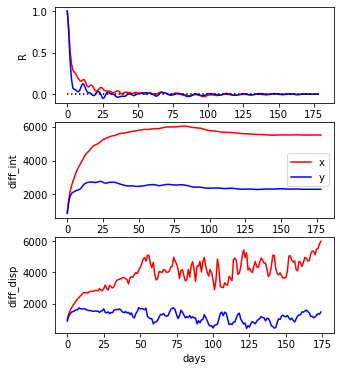

In [11]:
rx_r=((np.nanmean(rx,axis=1))/np.nanmean(rx[0,:]))
ry_r=((np.nanmean(ry,axis=1))/np.nanmean(ry[0,:]))
fig= plt.figure(figsize=(5,6))
plt.subplot(311)
plt.plot(rx_r,'r')
plt.plot(ry_r,'b')
plt.ylabel('R')
plt.plot([0,180],[0,0],':k')

plt.subplot(312)
diffx=np.nanmean(rx[0,:])*np.cumsum(rx_r)*24*3600
diffy=np.nanmean(ry[0,:])*np.cumsum(ry_r)*24*3600
plt.plot(diffx,'r')
plt.plot(diffy,'b')
plt.legend(['x','y'])
plt.ylabel('diff_int')

plt.subplot(313)
diffx=0.5*(np.diff(dxdx,axis=0))/(3600*24*2)
difx=np.nanmean(diffx,axis=1)
diffy=0.5*(np.diff(dydy,axis=0))/(3600*24*2)
dify=np.nanmean(diffy,axis=1)
plt.plot(difx[:-4],'r')
plt.plot(dify[:-4],'b')
plt.xlabel('days')
plt.ylabel('diff_disp')